In [59]:
import numpy as np
import pandas as pd
%load_ext memory_profiler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
import emoji 
import re,string
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
df = pd.read_csv("cyberbullying_tweets.csv")
stopwords = set(stopwords.words('english'))
sns.set_theme(style="whitegrid")

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


# Exploratory Data Analysis

### Getting the basic information about the data

In [60]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [61]:
df.describe()

,tweet_text,cyberbullying_type
count,47692,47692
unique,46017,6
top,@brianfenton D: php D:,religion
freq,2,7998


In [62]:
df.columns

Index(['tweet_text', 'cyberbullying_type'], dtype='object')

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


### Dropping Duplicates in the dataset.

In [64]:
df.duplicated().sum()

36

In [65]:
df.drop_duplicates("tweet_text",inplace=True)

In [66]:
df.duplicated().sum()

0

### Cleaning the data

In [67]:
## twitter text cleaning pattern from https://www.kaggle.com/paoloripamonti/twitter-sentiment-analysis
## text cleaning functions from https://www.kaggle.com/mohamedbakrey/work-on-classification-cyberbullying-using-ml-dp

def remove_emoji(text):
    # Removing emojis
    text = re.sub(emoji.get_emoji_regexp(),'',text)
    return text

def clean_text(text):
    text = text.replace('\n', '').replace('\r', '') # remove new lines and carriage returns
    text = text.lower()
    text = re.sub(r"(?:\@|https?\://)\S+", '', text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]','', text) #remove non-ascii characters
    table = str.maketrans("","",string.punctuation) #remove punctuation
    text = text.translate(table)
    text = [word for word in text.split() if word not in stopwords] #remove stopwords
    text = ' '.join(text)
    return text

def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

def clean_hashtags(text):
    new_text = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', text)) #remove last hashtags
    new_text2 = " ".join(word.strip() for word in re.split('#|_', new_text)) #remove hashtags symbol from words in the middle of the sentence
    return new_text2

#Filter special characters such as "&" and "$" present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

#Remove multiple sequential spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

In [68]:
def stemmer(text):
    tokenized_text = nltk.word_tokenize(text)
    stemmer = PorterStemmer()
    return ' '.join([stemmer.stem(word) for word in tokenized_text])
    

In [69]:
def clean_and_stem(text):
    text = remove_emoji(text)
    text = clean_text(text)
    text = decontract(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    return text

In [70]:
new_tweets = []
for tweet in df.tweet_text:
    new_tweets.append(clean_and_stem(tweet))
new_tweets = pd.Series(new_tweets)

### Visualizing the data
First we will plot the most frequent words in this dataset before cleaning.

<AxesSubplot:xlabel='count', ylabel='word'>

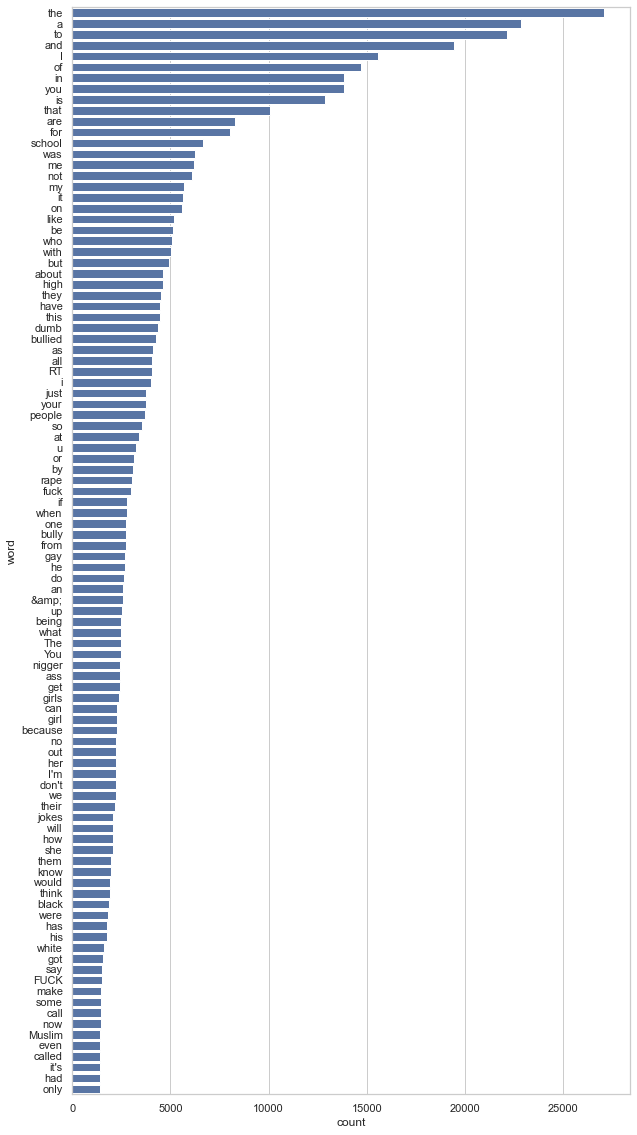

In [71]:
freq_table = pd.DataFrame(Counter(" ".join(df["tweet_text"]).split()).most_common(100),columns=["word","count"])# Getting the most common words

f, ax = plt.subplots(figsize=(10, 20))
sns.barplot(x="count", y="word", data=freq_table, label="Total", color="b")

After cleaning, we will plot the most frequent words in the dataset again.

<AxesSubplot:xlabel='count', ylabel='word'>

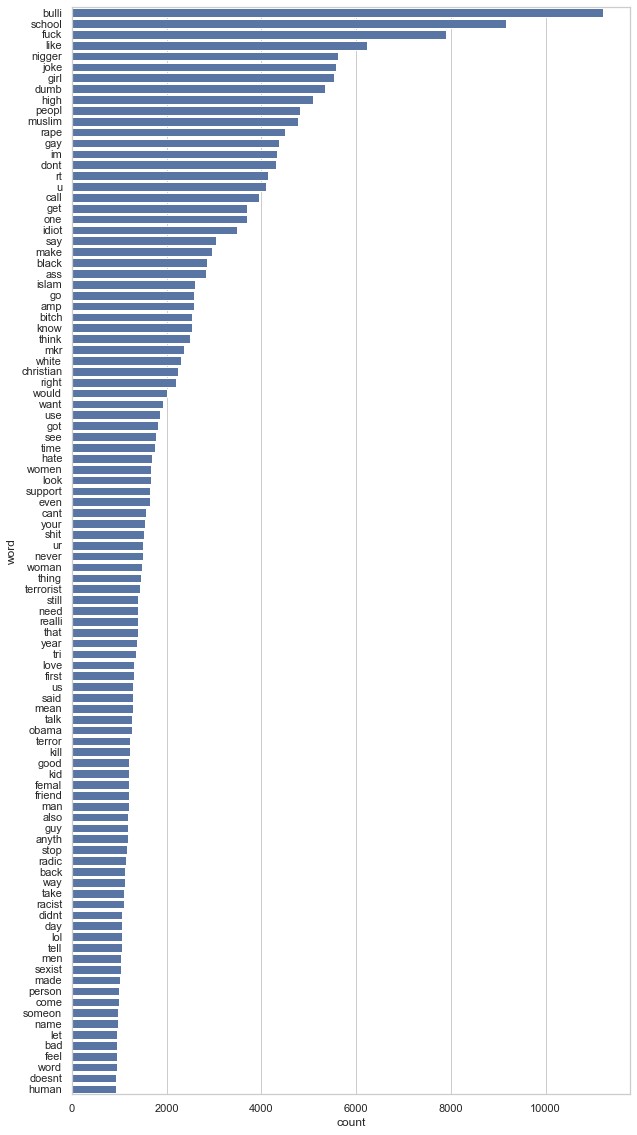

In [72]:
freq_table = pd.DataFrame(Counter(" ".join(new_tweets).split()).most_common(100),columns=["word","count"])# Getting the most common words

f, ax = plt.subplots(figsize=(10, 20))
sns.barplot(x="count", y="word", data=freq_table, label="Total", color="b")

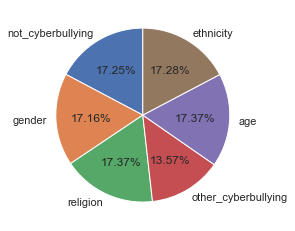

In [73]:
bully_type_freq = Counter(df["cyberbullying_type"])
total = sum(bully_type_freq.values())
bully_type_freq = {k: v / total for k, v in bully_type_freq.items()}
percentiles = [bully_type_freq[k] for k in bully_type_freq]
labels = [k for k in bully_type_freq]
plt.pie(percentiles,labels = labels,autopct='%1.2f%%',startangle=90,normalize=True)
plt.show()

### Machine Learning

In [74]:
cv = CountVectorizer(max_features=2500)
X = new_tweets
lb = LabelEncoder()
y = lb.fit_transform(df['cyberbullying_type'])
X = cv.fit_transform(X).toarray()

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [76]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)


In [77]:
gnb_score = gnb.score(X_test, y_test)
print("Accuracy of GaussianNB:",gnb_score)

Accuracy of GaussianNB: 0.5836592785745328


In [78]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

MultinomialNB()

In [79]:
mnb_score = mnb.score(X_test, y_test)
print("Accuracy of MultinomialNB:",mnb_score)

Accuracy of MultinomialNB: 0.7810734463276836


In [80]:
# Fitting K-NN to the Training set
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [81]:
knn_score=classifier.score(X_test,y_test)
print("Accuracy of K-NN:",knn_score)

Accuracy of K-NN: 0.7253368100825728


### Model Performances

Text(0.35, 2.07, '0.7810734463276836')

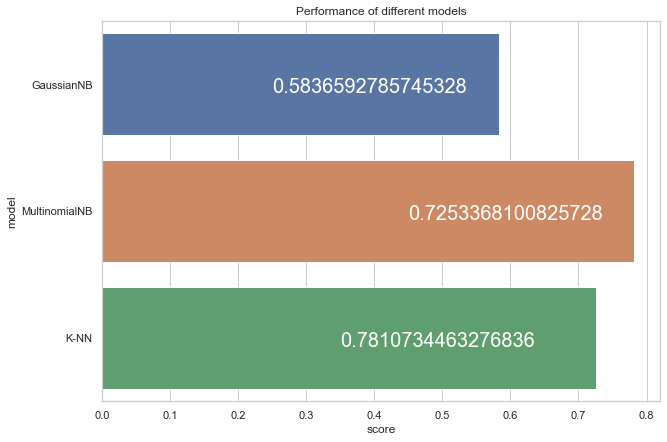

In [166]:
models = np.array(["GaussianNB","MultinomialNB","K-NN"])
scores = np.array([gnb_score,mnb_score,knn_score])
models_data = pd.DataFrame({"model":models,"score":scores})
f, ax = plt.subplots(figsize=(10, 7))
sns.barplot(y="model",x="score", data=models_data,orient="h",n_boot=100)
ax.set_title("Performance of different models")
ax.text(0.45, 1.07,knn_score, fontsize=20,color="white") #knn_score
ax.text(0.25, 0.07,gnb_score, fontsize=20,color="white") #knn_score
ax.text(0.35, 2.07,mnb_score, fontsize=20,color="white") #knn_score